In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Project5/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/Project5'

In [17]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/final_features/BtcFinalFeatures.csv"))
df.head()

,Date,Bitcoin_Close,Nasdaq_Close_lag1,CPI,Debt_to_GDP_lag365,Debt_to_GDP_lag90,Gold_Close_lag7,Gold_Close_lag365,CPI_pct_change_365d,Fed_Funds_Rate_lag365,CPI_pct_change_90d,Fed_Funds_Rate_lag90,Consumer_Sentiment,Nasdaq_365d_return,Unemployment_Rate,Ten_Year_Yield,Unemployment_Rate_lag30,Unemployment_Rate_lag90
0,2011-07-18,13.1600,2789.800049,225.395,89.56528,92.1938,1548.800049,1181.699951,0.035799,0.18,0.00581,0.1,63.7,566.880127,9.0,2.94,9.1,9.1
1,2011-07-19,13.4800,2765.110107,225.395,89.56528,92.1938,1561.900024,1181.699951,0.035799,0.18,0.00581,0.1,63.7,628.290039,9.0,2.91,9.1,9.1
2,2011-07-20,13.8502,2826.520020,225.395,89.56528,92.1938,1585.199951,1191.500000,0.035799,0.18,0.00581,0.1,63.7,591.739990,9.0,2.96,9.1,9.1
3,2011-07-21,13.6894,2814.229980,225.395,89.56528,92.1938,1589.000000,1191.599976,0.035799,0.18,0.00581,0.1,63.7,647.099854,9.0,3.03,9.1,9.1
4,2011-07-22,13.6100,2834.429932,225.395,89.56528,92.1938,1589.800049,1195.500000,0.035799,0.18,0.00581,0.1,63.7,612.940186,9.0,2.99,9.1,9.1


<Axes: xlabel='Bitcoin_Close', ylabel='Count'>

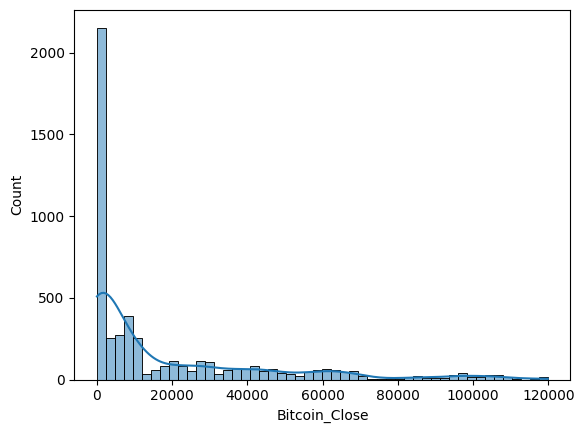

In [18]:
import seaborn as sns
sns.histplot(df['Bitcoin_Close'], bins=50, kde=True)

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define transformations
def apply_transform(y, method):
    if method == 'log_e':
        return np.log1p(y)
    elif method == 'log_10':
        return np.log10(y + 1)
    elif method == 'reciprocal':
        return 1 / (y + 1e-6)
    elif method == 'power':
        return np.power(y, 0.5)
    elif method == 'box_cox':
        pt = PowerTransformer(method='box-cox')
        return pt.fit_transform(y.values.reshape(-1, 1)).flatten()
    elif method == 'yeo_johnson':
        pt = PowerTransformer(method='yeo-johnson')
        return pt.fit_transform(y.values.reshape(-1, 1)).flatten()
    elif method == 'quantile_normal':
        qt = QuantileTransformer(output_distribution='normal', random_state=0)
        return qt.fit_transform(y.values.reshape(-1, 1)).flatten()
    else:
        return y

# List of transformations to test
transformers = ['log_e', 'log_10', 'reciprocal', 'power', 'box_cox', 'yeo_johnson', 'quantile_normal']

# Prepare features and target
X = df.drop(columns=['Bitcoin_Close', 'Date'])
y_raw = df['Bitcoin_Close']

# Chronological split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_raw, y_test_raw = y_raw.iloc[:split_idx], y_raw.iloc[split_idx:]

# Store results
results = []

for method in transformers:
    try:
        y_train = apply_transform(y_train_raw, method)
        y_test = apply_transform(y_test_raw, method)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Transformation': method,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
    except Exception as e:
        results.append({
            'Transformation': method,
            'Error': str(e)
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df.sort_values('R2', ascending=False))



    Transformation          MSE       RMSE        MAE            R2
3            power  3635.364329  60.293983  53.464107  1.334368e-01
6  quantile_normal    11.209123   3.348003   3.188711 -9.738197e+00
4          box_cox    13.017351   3.607957   3.526180 -1.201735e+01
5      yeo_johnson    13.029635   3.609659   3.528003 -1.202964e+01
0            log_e    33.113387   5.754423   5.231055 -9.374549e+01
1           log_10     6.245572   2.499114   2.271818 -9.374549e+01
2       reciprocal     0.009673   0.098349   0.084484 -4.358088e+07


In [20]:
df['Bitcoin_Close_Power'] = np.power(df['Bitcoin_Close'], 0.5)

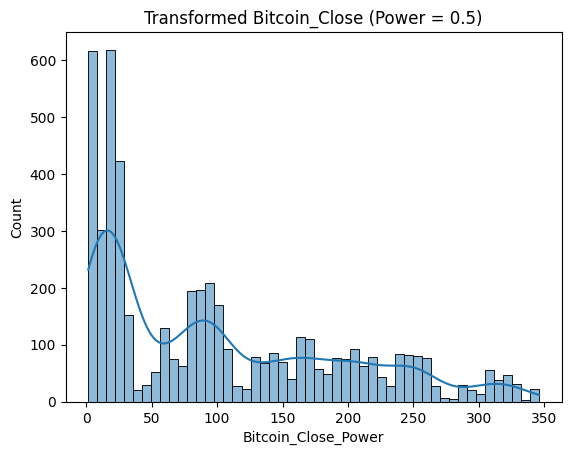

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Bitcoin_Close_Power'], bins=50, kde=True)
plt.title('Transformed Bitcoin_Close (Power = 0.5)')
plt.xlabel('Bitcoin_Close_Power')
plt.ylabel('Count')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(
    df.drop(['Bitcoin_Close', 'Date', 'Bitcoin_Close_Power'], axis=1),
    df['Bitcoin_Close_Power'],
    test_size=0.2,
    shuffle=False,
    random_state=0
)

print(f"features_train shape: {features_train.shape} \nfeatures_test shape: {features_test.shape}")
print(f"target_train shape: {target_train.shape} \ntarget_test shape: {target_test.shape}")

features_train shape: (4103, 16) 
features_test shape: (1026, 16)
target_train shape: (4103,) 
target_test shape: (1026,)


In [12]:
features_train.to_csv("outputs/datasets/train_test_initial/features_train_power.csv", index=False)

In [13]:
features_test.to_csv("outputs/datasets/train_test_initial/features_test_power.csv", index=False)

In [14]:
target_train.to_csv("outputs/datasets/train_test_initial/target_train_power.csv", index=False)

In [15]:
target_test.to_csv("outputs/datasets/train_test_initial/target_test_power.csv", index=False)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Bitcoin_Close_power'], bins=50, kde=True)
plt.title('Transformed Bitcoin_Close (Power = 0.5)')
plt.xlabel('Bitcoin_Close_power')
plt.ylabel('Count')
plt.show()

KeyError: 'Bitcoin_Close_power'